### Imports

In [1]:
import os
import gc
import glob
import json
from collections import defaultdict
import multiprocessing as mp
from pathlib import Path
from types import SimpleNamespace
from typing import Dict, List, Optional, Tuple
import warnings

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import PIL.Image as Image
from sklearn.metrics import fbeta_score
from sklearn.exceptions import UndefinedMetricWarning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from tqdm import tqdm

### Set up data

In [2]:
PREFIX = 'kaggle//input//vesuvius-challenge//train//1//' 
BUFFER = 30  # Buffer size in x and y direction
Z_START = 16 # First slice in the z direction to use
Z_DIM = 32   # Number of slices in the z direction
TRAINING_EPOCHS = 30000
VALIDATION_EPOCHS= 1000
LEARNING_RATE = 0.03
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class SubvolumeDataset(data.Dataset):
    def __init__(self, image_stack, label, pixels):
        self.image_stack = image_stack
        self.label = label
        self.pixels = pixels
    def __len__(self):
        return len(self.pixels)
    def __getitem__(self, index):
        y, x = self.pixels[index]
        subvolume = self.image_stack[:, y-BUFFER:y+BUFFER+1, x-BUFFER:x+BUFFER+1].view(1, Z_DIM, BUFFER*2+1, BUFFER*2+1)
        inklabel = self.label[y, x].view(1)
        return subvolume, inklabel   

In [4]:
images = [np.array(Image.open(filename), dtype=np.float32)/65535.0 for filename in tqdm(sorted(glob.glob(PREFIX+ "surface_volume/*.tif"))[Z_START:Z_START+Z_DIM])]
image_stack = torch.stack([torch.from_numpy(image) for image in images], dim=0).to(DEVICE)




100%|██████████| 32/32 [00:22<00:00,  1.44it/s]


In [5]:
mask = np.array(Image.open(PREFIX+"mask.png").convert('1'))
label = torch.from_numpy(np.array(Image.open(PREFIX+"inklabels.png"))).gt(0).float().to(DEVICE)

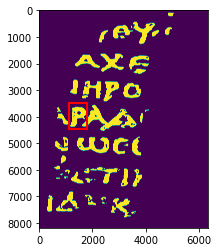

Generating pixel lists...


In [6]:
rect = (1100, 3500, 700, 950)
#rect = (1500, 2500, 1200, 1200)
fig, ax = plt.subplots()
ax.imshow(label.cpu())
patch = patches.Rectangle((rect[0], rect[1]), rect[2], rect[3], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(patch)
plt.show()


print("Generating pixel lists...")
# Split our dataset into train and val. The pixels inside the rect are the 
# val set, and the pixels outside the rect are the train set.
# Adapted from https://www.kaggle.com/code/jamesdavey/100x-faster-pixel-coordinate-generator-1s-runtime
# Create a Boolean array of the same shape as the bitmask, initially all True
not_border = np.zeros(mask.shape, dtype=bool)
not_border[BUFFER:mask.shape[0]-BUFFER, BUFFER:mask.shape[1]-BUFFER] = True
arr_mask = np.array(mask) * not_border
inside_rect = np.zeros(mask.shape, dtype=bool) * arr_mask
# Sets all indexes with inside_rect array to True
inside_rect[rect[1]:rect[1]+rect[3]+1, rect[0]:rect[0]+rect[2]+1] = True
# Set the pixels within the inside_rect to False
outside_rect = np.ones(mask.shape, dtype=bool) * arr_mask
outside_rect[rect[1]:rect[1]+rect[3]+1, rect[0]:rect[0]+rect[2]+1] = False
pixels_inside_rect = torch.tensor(np.argwhere(inside_rect)).to(DEVICE)
pixels_outside_rect = torch.tensor(np.argwhere(outside_rect)).to(DEVICE)

In [7]:
%%time
train_dset = SubvolumeDataset(image_stack,label, pixels_outside_rect)
val_dset = SubvolumeDataset(image_stack, label, pixels_inside_rect)

print("Num items (pixels)", len(train_dset))

Num items (pixels) 28470276
CPU times: user 167 µs, sys: 198 µs, total: 365 µs
Wall time: 234 µs


#### Sanity check 

In [8]:
BATCH_SIZE = 32
train_loader = data.DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = data.DataLoader(val_dset, batch_size=BATCH_SIZE, shuffle=True)
print("Num of Training batches:", len(train_loader))
print("Num of Training batches:", len(val_loader))

Num of Training batches: 889697
Num of Training batches: 20833


### Set up model

In [9]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [10]:
class InkDetector(torch.nn.Module):
    def __init__(self):
        super().__init__()

        filters = [16, 32, 64]
        paddings = [1, 1, 1]
        kernel_sizes = [3, 3, 3]
        strides = [2, 2, 2]
        
        layers = []
        in_channels = 1
        for num_filters, padding, kernel_size, stride in zip(filters, paddings, kernel_sizes, strides):
            layers.extend([
                nn.Conv3d(
                    in_channels=in_channels,
                    out_channels=num_filters,
                    kernel_size=kernel_size,
                    stride=stride,
                    padding=padding,
                ),
                nn.ReLU(inplace=True),
                torch.nn.BatchNorm3d(num_features=num_filters)
            ])
            in_channels = num_filters
        layers.append(nn.AdaptiveAvgPool3d(1))
        layers.append(nn.Flatten())

        self.encoder = nn.Sequential(*layers)
        self.decoder = nn.Sequential(
            nn.Linear(in_channels, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        features = self.encoder(x)
        return self.decoder(features)

In [11]:
model = InkDetector().to(DEVICE)

## Visualization

In [12]:
# This function allows us to keep track of loss, fbeta and accuracy.
# The method update needs to be called to calculate loss, fbeta and accuracy.

class visualize:
    def __init__(self, epochs):
        """
        In here we initialize the values to 0
        """
        self.fbeta=0
        self.loss=0
        self.accuracy=0
        self.plot_loss=[]
        self.plot_acc=[]
        self.plot_fbeta=[]
        self.epochs=epochs
    def update(self, outputs, labels, loss):
        """
        Takes outputs, labels and loss as input and updates the instance variables fbeta, accuracy and loss
        
        """
        pred_labels = outputs.detach().sigmoid().gt(0.4).int()
        accuracy = (pred_labels == labels).sum().float().div(labels.size(0))
        self.fbeta += fbeta_score(labels.view(-1).cpu().numpy(), pred_labels.view(-1).cpu().numpy(), beta=0.5)
        self.accuracy += accuracy.item()
        self.loss += loss.item()
        
    def append(self):
        """
        Appends items to loss, fbeta and accuracy
        """
        self.plot_loss.append(self.loss/self.epochs)
        self.plot_acc.append(self.accuracy/self.epochs)
        self.plot_fbeta.append(self.fbeta/self.epochs)
        
    def reset(self):
        """
        Resets the instance variable fbeta, accuracy and loss to 0
        """
        self.loss=0
        self.accuracy=0
        self.fbeta=0
        

### Train

In [13]:
TRAIN_RUN = True # To avoid re-running when saving the notebook

In [14]:
warnings.simplefilter('ignore', UndefinedMetricWarning)

In [15]:
if TRAIN_RUN:
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE, total_steps=TRAINING_EPOCHS)
    model.train()
    
    
    
    # We will use these to visualize training
    train_visualize= visualize(500) # The 500 here should be the same number as 500 below. 
    val_visualize=visualize(VALIDATION_EPOCHS)

    
    #denom = 0
    pbar = tqdm(enumerate(train_loader), total=TRAINING_EPOCHS)
    for i, (subvolumes, inklabels) in pbar:
        if i >= TRAINING_EPOCHS:
            break
        optimizer.zero_grad()
        outputs = model(subvolumes.to(DEVICE))
        loss = criterion(outputs, inklabels.to(DEVICE))
        loss.backward()
        optimizer.step()
        scheduler.step()
        # Updates the training_loss, training_fbeta and training_accuracy
        train_visualize.update(outputs, inklabels, loss) 
        #denom += 1
        #pbar.set_postfix({"Loss": running_loss / denom, "Accuracy": running_accuracy / denom, "Fbeta@0.5": running_fbeta / denom})
        if (i + 1) % 500 == 0:
            train_visualize.append()
            val_visualize.append()
            train_visualize.reset()
            val_visualize.reset()
            for j, (val_subvolumes, val_inklabels) in enumerate(val_loader):
                if j>= VALIDATION_EPOCHS:
                    break
                val_outputs= model(val_subvolumes.to(DEVICE))
                val_loss = criterion(val_outputs, val_inklabels.to(DEVICE))
                val_visualize.update(val_outputs, val_inklabels, val_loss) 
    torch.save(model.state_dict(), "model1.pt")

else:
    model_weights = torch.load("model1.pt")
    model.load_state_dict(model_weights)

100%|██████████| 30000/30000 [20:37<00:00, 24.24it/s]  


Let us visualise the training loss, accuracy and fbeta as the network trains!

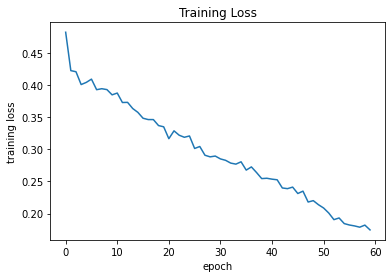

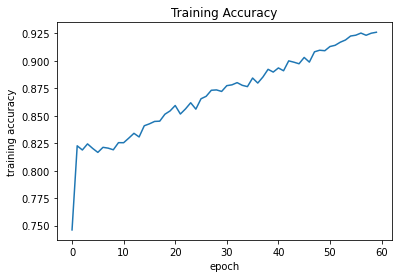

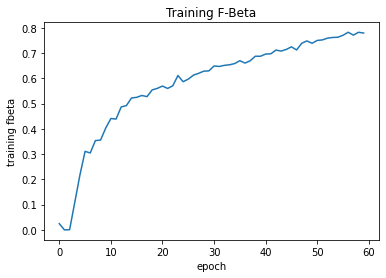

In [16]:
if TRAIN_RUN:
    # Plotting the training_loss vs epochs
    plt.plot(train_visualize.plot_loss)
    plt.xlabel('epoch')
    plt.ylabel('training loss')
    plt.title("Training Loss")
    plt.savefig("train_loss_plot.png", format="png")
    plt.show()

    # Plotting the training accuracy
    plt.plot(train_visualize.plot_acc)
    plt.xlabel('epoch')
    plt.ylabel('training accuracy')
    plt.title("Training Accuracy")
    plt.savefig("train_accuracy_plot.png", format="png")
    plt.show()

    # Plotting the training fbeta@0.5
    plt.plot(train_visualize.plot_fbeta)
    plt.xlabel('epoch')
    plt.ylabel('training fbeta')
    plt.title("Training F-Beta")
    plt.savefig("train_fbeta_plot.png", format="png")
    plt.show()


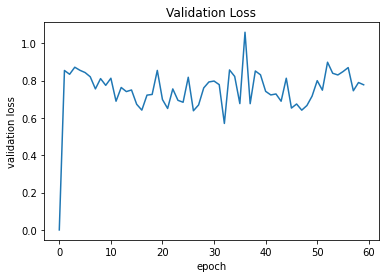

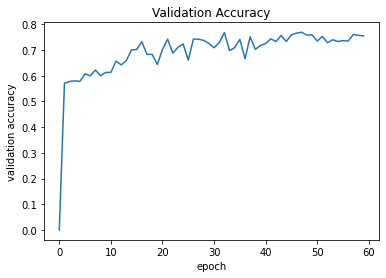

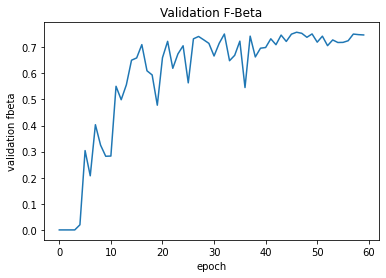

In [17]:
if TRAIN_RUN:
    # Plotting the training_loss vs epochs
    plt.plot(val_visualize.plot_loss)
    plt.xlabel('epoch')
    plt.ylabel('validation loss')
    plt.title("Validation Loss")
    plt.savefig("val_loss_plot.png", format="png")
    plt.show()

    # Plotting the training accuracy
    plt.plot(val_visualize.plot_acc)
    plt.xlabel('epoch')
    plt.ylabel('validation accuracy')
    plt.title("Validation Accuracy")
    plt.savefig("val_accuracy_plot.png", format="png")
    plt.show()

    # Plotting the training fbeta@0.5
    plt.plot(val_visualize.plot_fbeta)
    plt.xlabel('epoch')
    plt.ylabel('validation fbeta')
    plt.title("Validation F-Beta")
    plt.savefig("val_fbeta_plot.png", format="png")
    plt.show()

### Evaluate

In [18]:
# Clear memory before loading test fragments
train_dset.labels = None
train_dset.image_stacks = []
del train_loader, train_dset
gc.collect()

19255

In [19]:
test_path = base_path / "test"
test_fragments = [train_path / fragment_name for fragment_name in test_path.iterdir()]
print("All fragments:", test_fragments)

NameError: name 'base_path' is not defined

In [ ]:
pred_images = []
model.eval()

outputs = []
eval_dset = SubvolumeDataset(image_stack, label, pixels_inside_rect)
eval_loader = data.DataLoader(eval_dset, batch_size=BATCH_SIZE, shuffle=False)
with torch.no_grad():
    for i, (subvolumes, _) in enumerate(tqdm(eval_loader)):
        output = model(subvolumes.to(DEVICE)).view(-1).sigmoid().cpu().numpy()
        outputs.append(output)
# we only load 1 fragment at a time
image_shape = eval_dset.image_stack[0].shape
eval_dset.labels = None
eval_dset.image_stack = None
del eval_loader
gc.collect()

pred_image = np.zeros(image_shape, dtype=np.uint8)
outputs = np.concatenate(outputs)
for (y, x), prob in zip(eval_dset.pixels[:outputs.shape[0]], outputs):
    pred_image[y ,x] = prob > 0.4
pred_images.append(pred_image)
    
eval_dset.pixels = None
del eval_dset
gc.collect()
#print("Finished", test_fragment)

In [ ]:
plt.imshow(pred_images[0], cmap='gray')

### Submission

In [ ]:
def rle(output):
    flat_img = np.where(output > 0.4, 1, 0).astype(np.uint8)
    starts = np.array((flat_img[:-1] == 0) & (flat_img[1:] == 1))
    ends = np.array((flat_img[:-1] == 1) & (flat_img[1:] == 0))
    starts_ix = np.where(starts)[0] + 2
    ends_ix = np.where(ends)[0] + 2
    lengths = ends_ix - starts_ix
    return " ".join(map(str, sum(zip(starts_ix, lengths), ())))

In [ ]:
submission = defaultdict(list)
for fragment_id, fragment_name in enumerate(test_fragments):
    submission["Id"].append(fragment_name.name)
    submission["Predicted"].append(rle(pred_images[fragment_id]))

pd.DataFrame.from_dict(submission).to_csv("/kaggle/working/submission.csv", index=False)

In [ ]:
pd.DataFrame.from_dict(submission)